# Quick Start Examples - Hierarchical Retail Data

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:

import numpy as np
import pandas as pd
import os 
import seaborn as sns

def create_hierarchy_col(df):
    df = df.copy(deep=True)
    df['hierarchy'] = df[fframe.hierarchy].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    return df


def assign_fake_hierarchy(data, hierarchy_tuple, hierarchy_cols, target='sales'):
    data = data.copy(deep=True)
    data['hierarchy'] = [hierarchy_tuple]*len(data)
    data[hierarchy_cols] = pd.DataFrame(data['hierarchy'].tolist(), index=data.index)
    data.drop('hierarchy', axis=1, inplace=True)

    data.rename({"y":"sales", "ds":"datetime"}, axis=1, inplace=True)
    data[target] = data[target] + np.random.normal(0, data[target].std()*.2, len(data))
    data.loc[data[target] < 0, target] = 0
    data[target] = data[target].astype(int)

    # change column order
    data = data[['datetime'] + hierarchy_cols + [target]]

    return data

# help ipython find our path
directory = os.path.dirname(os.path.abspath(''))
os.chdir(directory)

import forecastframe as ff


In [3]:
# hierarchical_data = pd.read_csv("./forecastframe/sample_data/daily/small.csv") # decided to create fake data instead of using this messy hierarchical data from kaggle

data = pd.read_csv("https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv")

In [4]:
# create fake hierarchical retail dataset
hierarchy_cols = ['state', 'store_id', 'category', 'sku']

stores_per_state = 1
states = ('CO', 'TX', 'CA')

categories = ('FOOD', 'APPAREL')
skus_per_dept = 2

fake_hierarchy = tuple(((state, f"{state}_{store_id}", cat, f"{cat}_{sku}") for cat in categories for sku in range(skus_per_dept) for state in states for store_id in range(stores_per_state)))

df = pd.concat([assign_fake_hierarchy(data, hierarchy_tuple, hierarchy_cols=hierarchy_cols) for hierarchy_tuple in fake_hierarchy])
df.to_csv('./forecastframe/sample_data/daily/mock_hierarchical_retail_sales.csv', index=False)

In [5]:
df

,datetime,state,store_id,category,sku,sales
0,1992-01-01,CO,CO_0,FOOD,FOOD_0,140593
1,1992-02-01,CO,CO_0,FOOD,FOOD_0,116748
2,1992-03-01,CO,CO_0,FOOD,FOOD_0,181757
3,1992-04-01,CO,CO_0,FOOD,FOOD_0,164187
4,1992-05-01,CO,CO_0,FOOD,FOOD_0,165672
...,...,...,...,...,...,...
288,2016-01-01,CA,CA_0,APPAREL,APPAREL_1,404372
289,2016-02-01,CA,CA_0,APPAREL,APPAREL_1,394103
290,2016-03-01,CA,CA_0,APPAREL,APPAREL_1,473664
291,2016-04-01,CA,CA_0,APPAREL,APPAREL_1,443208


In [6]:
fframe = ff.ForecastFrame(data=df, target="sales", datetime_column="datetime", hierarchy=hierarchy_cols)

### Prophet

Importing plotly failed. Interactive plots will not work.


Initial log joint probability = -8.66017
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9981.57     0.0208444       2478.09           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10045.1    0.00861285       1961.91           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       10072.6   0.000775443       876.775      0.5591      0.5591      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399         10084     0.0423451       436.096           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       10092.8    0.00341773       714.864           1           1      564   
    Iter      log prob        ||dx||      ||grad||       alpha  

<AxesSubplot:xlabel='datetime', ylabel='sales'>

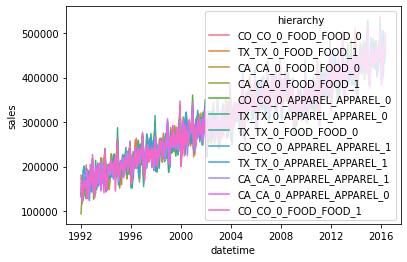

In [7]:
fframe.predict(model="prophet", future_periods=10, weekly_seasonality=True, daily_seasonality=True)
predictions = create_hierarchy_col(fframe.get_predictions()).reset_index()

sns.lineplot(data=predictions, x='datetime', y='sales', hue='hierarchy')

In [8]:
fframe.cross_validate(folds=3, model="prophet")

Initial log joint probability = -4.94985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2135.18    0.00195543       127.535      0.4866      0.4866      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       2136.24   0.000214972       108.914   2.401e-06       0.001      241  LS failed, Hessian reset 
     192       2136.29   0.000131856       94.5812   1.485e-06       0.001      311  LS failed, Hessian reset 
     199        2136.3   2.93601e-05       81.7824      0.1952           1      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236        2136.3   6.30029e-08       78.4799      0.4334      0.4334      367   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.94985
    Iter      log prob        ||dx||      ||grad||   

In [ ]:
# check that the latest round of predictions stored in the object were created using the params found in cross-validation
assert fframe.model_object.seasonality_mode == fframe.cross_validations[-1]["best_params"]["seasonality_mode"]

In [ ]:
fframe.get_cross_validation_errors()

[{'In-Sample':              Actuals    Predictions  Absolute Percent Error  Absolute Error  \
  count     879.000000     879.000000              879.000000      879.000000   
  mean   197834.048919  197845.209233                0.091957    17707.608213   
  std     31955.812677   22508.651464                0.076847    14127.119268   
  min    104491.000000  151575.219605                0.000032        5.791836   
  25%    175387.500000  180298.871349                0.034101     6758.649332   
  50%    197811.000000  200035.969874                0.073931    14328.964932   
  75%    219681.000000  214843.732467                0.129338    24986.212411   
  max    295929.000000  236605.043108                0.504287    77885.405618   
  
         Squared Error  
  count   8.790000e+02  
  mean    5.129078e+08  
  std     7.940893e+08  
  min     3.354537e+01  
  25%     4.567950e+07  
  50%     2.053192e+08  
  75%     6.243109e+08  
  max     6.066136e+09  ,
  'Out-of-Sample':           

### LightGBM

<AxesSubplot:xlabel='datetime'>

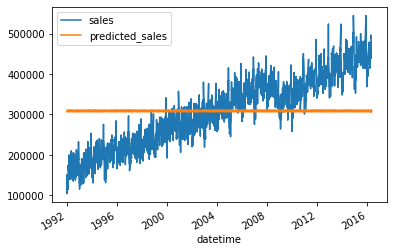

In [ ]:
# Predictions are weak because our model doesn't have any features to grip on
# Note we can pass in lightgbm params as kwargs, such as learning_rate
fframe.predict(model="lightgbm", future_periods=10, learning_rate=.04)
fframe.get_predictions().plot.line()

In [ ]:
# Let's add some features to help our model out
#fframe.calc_datetime_features()
fframe.lag_features(features=[fframe.target], lags=[1, 2, 3, 12]) # lagged features for 1 month ago, 2 months ago ..., 12 months ago
fframe.calc_statistical_features(features=[fframe.target], windows=[3, 6, 12], aggregations=['mean', 'std']) # 3, 6, and 12 month rolling aggregations for both mean and std
fframe.calc_ewma(fframe.target, windows=[3, 6, 12]) # 3, 6, 12 month exponential weighted moving averages

fframe.get_sample()

Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


,sales,state,store_id,category,sku,sales_lag1,sales_lag2,sales_lag3,sales_lag12,sales_mean_roll3_lag1,sales_std_roll3_lag1,sales_mean_roll6_lag1,sales_std_roll6_lag1,sales_mean_roll12_lag1,sales_std_roll12_lag1,sales_ewma_roll3_lag1,sales_ewma_roll6_lag1,sales_ewma_roll12_lag1
datetime,,,,,,,,,,,,,,,,,,
1992-01-01,149297,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-02-01,133482,1,1,0,0,149297.0,NaN,NaN,NaN,128038.0,NaN,128038.0,NaN,128038.0,NaN,NaN,NaN,NaN
1992-03-01,143690,1,1,0,0,133482.0,149297.0,NaN,NaN,143443.0,NaN,143443.0,NaN,143443.0,NaN,NaN,NaN,NaN
1992-04-01,153551,1,1,0,0,143690.0,133482.0,149297.0,NaN,139597.0,NaN,139597.0,NaN,139597.0,NaN,141574.428571,NaN,NaN
1992-05-01,196679,1,1,0,0,153551.0,143690.0,133482.0,NaN,173937.0,NaN,173937.0,NaN,173937.0,NaN,147961.933333,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-09-01,226087,1,1,0,1,288303.0,273887.0,318492.0,284159.0,506377.0,NaN,506377.0,NaN,506377.0,NaN,285440.057125,280064.182276,275775.576708
2001-10-01,268388,1,1,0,1,226087.0,288303.0,273887.0,302528.0,413552.0,NaN,413552.0,NaN,413552.0,NaN,255763.528562,264642.130197,268131.180267
2001-11-01,294229,1,1,0,1,268388.0,226087.0,288303.0,267347.0,422971.0,NaN,422971.0,NaN,422971.0,NaN,262075.764281,265712.378712,268170.690995


Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


<AxesSubplot:xlabel='datetime'>

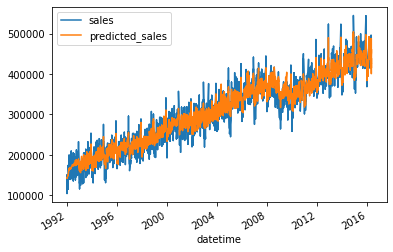

In [ ]:
fframe.predict(model="lightgbm", future_periods=10, learning_rate=.04)
fframe.get_predictions().plot.line()

In [ ]:
fframe.get_errors()

,Actuals,Predictions,Absolute Percent Error,Absolute Error,Squared Error
count,879.000000,879.000000,879.000000,879.000000,8.790000e+02
mean,412109.935154,325528.241862,0.202639,87423.886986,1.006051e+10
std,41845.716874,13340.540938,0.098680,49196.830473,9.722348e+09
min,301727.000000,299168.881472,0.000260,86.777674,7.530365e+03
25%,379355.500000,315443.949484,0.125706,47736.460829,2.278770e+09
50%,411348.000000,325017.939506,0.206557,84642.416083,7.164339e+09
75%,440755.000000,334358.534356,0.280790,122483.495780,1.500227e+10
max,545113.000000,353578.107283,0.436845,237827.796682,5.656206e+10


In [ ]:
fframe.cross_validate(folds=3, model="lightgbm")

Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


Running fold 1 of 3 with train shape (879, 18) and test shape (879, 18)


Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


Running fold 2 of 3 with train shape (1758, 18) and test shape (879, 18)


Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


Running fold 3 of 3 with train shape (2637, 18) and test shape (879, 18)


Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


In [ ]:
fframe.save_fframe()

Saving to /home/nthor/forecastframe/forecastframe.pkl


In [ ]:
fframe

             sales  state  store_id  category  sku
datetime                                          
1992-01-01  149297      1         1         1    2
1992-01-01  138050      0         0         0    1
1992-01-01  139215      2         2         1    2
1992-01-01  137628      2         2         0    1
1992-01-01  128038      0         0         1    2
...            ...    ...       ...       ...  ...
2016-05-01  466707      0         0         1    2
2016-05-01  462395      2         2         1    2
2016-05-01  438861      1         1         1    2
2016-05-01  482652      2         2         0    1
2016-05-01  480826      0         0         0    1

[3516 rows x 5 columns]